# Precipitation Analysis : Historical and Contemporary Rainfall Patterns in the United States

## DATS 6103 Individual Project 2 : Mariko McDougall

### Statement of Purpose

This is an analysis project which looked at trends in rainfall duration, volume and intensity using an hourly precipitation dataset using weather stations located throughout the United States, collected from the 1950s to 2020. This analysis was performed for GWU's DATS 6103 - Introduction to Data Mining. 
The purpose of this analysis is to extract and examine data using publicly available datasets and draw conclusions, as well as make predictions using the findings.

All data sourcing, wrangling and anlalysis was performed in python using publicly available libraries.

### Data Source

Precipitation data is sourced from the NOAA (National Oceanic and Atmospheric Administration) National Centers for Environmental Information, and donloaded using their Hourly Precipitation Data API.

Hourly Precipitation Data (HPD) Network, Version 2.0  
NOAA National Centers for Environmental Information. [11-09-2020]  


To run this script, the only file needed is the station inventory, all other files will be iteratively downloaded using the API.  
https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/station-inventory/  


The full dataset can be accessed here: https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/
  

## Preliminary Examination / Data Wrangling

In [1]:
#Import all packages that will be used throughout the project
import os
import pandas as pd
import requests
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import concurrent.futures as cf

#Set working directory - will be the base path for our saved data.
wd=os.path.abspath('C://Users//Mariko//Documents//GitHub//The-5-PM-rains')
os.chdir(wd)

In [2]:
#Load the station inventory - downloaded from the NOAA data repository
station_inv=pd.read_csv('HPD_v02r02_stationinv_c20201027.csv')

#Filter to only keep the columns we need
station_inv=station_inv.filter(['StnID', 'Lat', 'Lon', 'Elev', 'State/Province', 'Name','POR_Date_Range'])
station_inv.head()

,StnID,Lat,Lon,Elev,State/Province,Name,POR_Date_Range
0,USC00010008,31.5702,-85.2482,139.0,AL,ABBEVILLE,19480601-20180418
1,USC00010063,34.2553,-87.1814,249.3,AL,ADDISON,19480601-20201014
2,USC00010140,32.2322,-87.4104,53.3,AL,ALBERTA,19630926-20201003
3,USC00010252,31.3071,-86.5226,76.2,AL,ANDALUSIA 3 W,19800301-20180205
4,USC00010369,33.2941,-85.7788,311.5,AL,ASHLAND 3 ENE,19480601-20130804


In [3]:
def download_state_data(filter_state):
    """
    Downloads the csv files for all weather stations in the state indicated.
    Will create the required data directories in the wd if they do not exist.
    
    Inputs:
    filter_state : The abbreviation(s) for the state(s) to be downloaded. 
                   Can be an individual str, or a list of str
    """
    
    #Load the station inventory 
    try:
        station_inv=pd.read_csv('HPD_v02r02_stationinv_c20201027.csv')
    except:
        raise ValueError('Please ensure the station inventory is in your workng directory.')
    
    #If filtering requested, only download those states
    if type(filter_state)==str:
        if filter_state.lower()!='all':
            filter_state=[filter_state]
        else:
            filter_state=station_inv['State/Province'].unique().tolist()
            filter_state=[ele for ele in filter_state if ele not in ['GU', 'AS', 'PR', 'VI', 'MP']] 
        
    station_inv=station_inv[station_inv['State/Province'].isin(filter_state)]
    
    #Format the start and end dates for downloading
    station_inv['Start_Date'] = station_inv["POR_Date_Range"].apply(lambda x : x.split('-')[0])
    station_inv['End_Date'] = station_inv["POR_Date_Range"].apply(lambda x : x.split('-')[1])
    
    station_inv['Start_Date'] = pd.to_datetime(station_inv['Start_Date'], format='%Y%m%d').dt.strftime("%Y-%m-%d"); 
    station_inv['End_Date'] = pd.to_datetime(station_inv['End_Date'], format='%Y%m%d').dt.strftime("%Y-%m-%d"); 
    
    
    #This is what the URL to be assembled looks like:
    #https://www.ncei.noaa.gov/access/services/data/v1?dataset=coop-hourly-precipitation&stations=USC00170273&dataTypes=HR00Val&startDate=2010-05-01&endDate=2010-05-31
    
    #General downloading set-up
    url_base='https://www.ncei.noaa.gov/access/services/data/v1?dataset=coop-hourly-precipitation&stations='
    
    #Create the datatype variables for the hourly data - 
    # HRXXVAL Where the 2 digits are the 24h clock time for that hour 
    #(eg, HR01Val is the hourly value for 1 AM)
    data_types='&dataTypes='
    for i in range(10):
        if i==0:
            data_types+='HR0'+str(i)+'Val'
        else:
            data_types+=',HR0'+str(i)+'Val'  
    for i in range(10, 24):
        data_types+=',HR'+str(i)+'Val'
    
    
    #Make the data folders for downloads, if needed
    for state in filter_state:
        if not os.path.isdir(f'./Stations/{state}'):
            os.makedirs(f'./Stations/{state}')
            

    def download_data(i):
        """
        Assemble the URLs and dowload the data to the appropriate directory

        Inputs:
        i : The filtered station inventory index to download
        """
        #Locate the row of data to download
        this_station=state_df.iloc[i,:]
        
        #Only download the data if you don't already have it.
        if f'{str(this_station.StnID)}.csv' not in os.listdir(f'./Stations/{this_station["State/Province"]}/'):   
    
            #Generate url and get the file from the NOAA website
            url=url_base+this_station.StnID+data_types+'&startDate='+this_station.Start_Date+'&endDate='+this_station.End_Date
            r = requests.get(url, allow_redirects=True)
            
            #Save to the station directory
            with open(f'./Stations/{this_station["State/Province"]}/{str(this_station.StnID)}.csv', 'wb') as outfile:
                outfile.write(r.content)   
    
    #Loop through the list of states
    for skim_state in filter_state:
        state_df=station_inv[station_inv['State/Province']==skim_state]
        

        #Loop for each station - each needs to be run seperately for the different start/stop dates
        with cf.ThreadPoolExecutor() as executor:
            #Thread to download multiple files quickly
            executor.map(download_data, range(state_df.shape[0]))


In [4]:
state_str='MD'

download_state_data(state_str)

In [5]:

def import_state_raw(state_str):
    """
    Loads the raw csv files for all stations in the state, returns as a single dataframe
    
    Inputs:
    state_str : The abbreviation for the state to be loaded. Must be str
    """
    
    #Make sure the state abbreviation is capitalized
    state_str=state_str.upper()
    
    #Check if the folder is there, and if the files are downloades
    if os.path.isdir('./Stations/'+state_str):
      if len(os.listdir())==0:
          raise ValueError('No data files found for that State. Please check that the data is downloaded.')
    else:
        raise ValueError('No data folder found for that State. Please check that the data is downloaded.')
    
    
    #Import the files from csv and concatinate 
    all_dfs=[pd.read_csv('./Stations/'+state_str+'/'+file) for file in os.listdir('./Stations/'+state_str)]
    df_raw=pd.concat(all_dfs, ignore_index=True )
    
    
    return df_raw

In [6]:
df_state=import_state_raw(state_str)
df_state.head()

,STATION,DATE,HR00Val,HR01Val,HR02Val,HR03Val,HR04Val,HR05Val,HR06Val,HR07Val,...,HR14Val,HR15Val,HR16Val,HR17Val,HR18Val,HR19Val,HR20Val,HR21Val,HR22Val,HR23Val
0,USC00180700,1948-05-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,USC00180700,1948-05-02,0,0,0,0,0,0,0,0,...,3,19,4,2,0,0,0,0,0,27
2,USC00180700,1948-05-03,53,11,2,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,USC00180700,1948-05-04,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,9,11,9
4,USC00180700,1948-05-05,25,36,19,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:

def reformat_imported_df(df_in):
    """
    Reformats the raw data for all stations in the state
    Adds the name of the station, as well as datetime columns for easier indexing
    Changed the column names to be more human-readable
    
    Inputs:
    df_in : The loaded dataframe containing the raw csv data from each state 
    """
    
    #Import the Station Inventory to get the Station name
    station_inv=pd.read_csv('HPD_v02r02_stationinv_c20201027.csv')
    station_inv.index=station_inv.StnID
    df_in.index=df_in.STATION
    
    #Add the Station name
    df_in["Station"]=station_inv.Name


    #Change the Date column to a date, seperate out values
    df_in["Date"]=pd.to_datetime(df_in["DATE"])
    df_in['Year']=df_in.Date.dt.year
    df_in['Month']=df_in.Date.dt.month
    df_in['Day']=df_in.Date.dt.day
    
    
    #Drop the poorly formatted columns (and a duplicate data column)    
    df_in.drop(['STATION', 'DATE' ], axis=1, inplace=True)
    
    
    #Rename the hours columns to be actual times
    def gen_hours():
        am=['12AM']+[str(i)+'AM' for i in range(1,12)]
        pm=['12PM']+[str(i)+'PM' for i in range(1,12)]
        return am+pm
    
    hours=dict(zip([x for x in df_in.columns if'HR' in x], gen_hours()))
    df_in=df_in.rename(columns=hours)
    
    
    #Reorder the columns
    cols=df_in.columns.to_list()
    cols=cols[-5:]+cols[:-5]
    df_in=df_in[cols]
    
    df_in=df_in.reset_index(drop=True)
    
    return df_in

In [8]:
df_state=reformat_imported_df(df_state)
df_state.head()

,Station,Date,Year,Month,Day,12AM,1AM,2AM,3AM,4AM,...,2PM,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM
0,BELTSVILLE,1948-05-01,1948,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BELTSVILLE,1948-05-02,1948,5,2,0,0,0,0,0,...,3,19,4,2,0,0,0,0,0,27
2,BELTSVILLE,1948-05-03,1948,5,3,53,11,2,1,1,...,0,0,0,0,0,0,0,0,0,0
3,BELTSVILLE,1948-05-04,1948,5,4,0,0,0,0,0,...,0,0,0,0,0,0,1,9,11,9
4,BELTSVILLE,1948-05-05,1948,5,5,25,36,19,1,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def remove_non_rain_days(df_in):
    """
    Remove all days in which there is zero precipitation
    This will make future processing faster, and removes unneded data.
    
    Inputs:
    df_in : The reformatted dataframe obtained from reformat_imported_df
    """
        
    #Remove -99999 entries- This is the missing data code
    #Note: This is NOT the same as a zero
    df_in=df_in.replace(-9999, np.NaN)
    df_in=df_in.dropna()
    
    #Take the sum of the hourly precipitation columns, if there is precipitation, keep row
    df_rain=df_in.iloc[:,5:].sum(axis=1)
    df_rain=df_rain>0
    
    out=df_in[df_rain]

    return out


In [10]:
start=df_state.shape[0]
df_state=remove_non_rain_days(df_state)
stop=df_state.shape[0]
print(f'{start-stop} Non-precipitation days removed.')
print(f'{stop} Precipitation days remaining.')

45778 Non-precipitation days removed.
19434 Precipitation days remaining.


In [11]:

def simple_annual_sums_line(df_in, state_str, print_legend=False):
    """
    Generate a simple line plot to look at the mean annual precipitation for each station in the state.
    
    Inputs:
    df_in : The dataframe with hourly rain data
    state_str: A string identifying which state the data belongs to - for title only
    print_legend: Print the names of each station - False by default, can be cluttered in high reporting states
    """
    
    #Generate the figure
    plt.figure(figsize=(11,4))
    
    #Loop through each station in the state
    for station in df_in.Station.unique():
        sat_ann=df_in[df_in.Station==station]
        
        #Get the total amount of precipitation reported per year
        annual_hourly=sat_ann.groupby(by='Year').sum()
        annual_sum=annual_hourly.sum(axis=1).reset_index()

        #Plot for that station
        plt.plot(annual_sum.Year, annual_sum.iloc[:,1], label=station)

    #Add the plot formatting
    plt.title(f'Annual Precipitation for each Station: {state_str}')
    plt.ylabel('Precipitation in 1/100 Inches')

    if print_legend == True:
        plt.legend()

    plt.show()

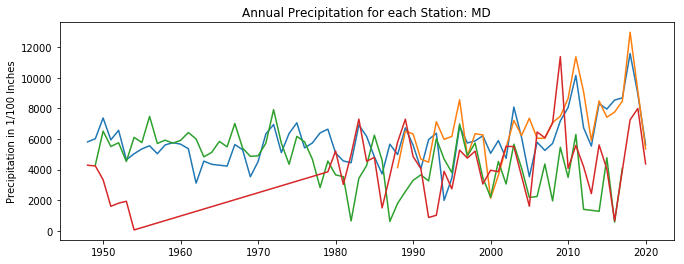

In [12]:
simple_annual_sums_line(df_state, state_str)

In [13]:
def filter_nonconsecutive_years(df_in, max_years_skipped=2):
    """
    Check to make sure all data is consecutive, and isn't missing large chunks of years in reporting
    Can happen when stations are being renovated or shut down temporarily - several years may be missing from the record.
    If large gap detected, will retain the data from the larger side of the missing data.
    
    Inputs:
    df_in : The dataframe with hourly rain data
    max_years_skipped: The maximum amount of consecutive years that can be missing before the data is sliced.
    """
    
    
    def check_consecutive(list_in, max_years_skipped):
        """
        Internal function that checks if an individual station is consecutive.
        Returns years that are consecutive, and if gaps are detected, returns the largest of the consecutive spans.

        Inputs:
        list_in : List of all years an idividual station reported data
        max_years_skipped: The maximum amount of consecutive years that can be missing before the data is sliced.
        """
        #Generate a list of all consecutive years data could be reported, based on that stations's first and last years
        #Compare actual years repored against this perfect list
        min_year=min(list_in)
        max_year=max(list_in)
        perfect_list=list(range(min_year,max_year+1))
       
        #If exact match - there are no gaps: return
        if perfect_list==list_in:
            return list_in
        else: 
            #Check if there are less total missing years than the threshold, if so: return.
            if len(perfect_list)-len(list_in)<=max_years_skipped:
                return list_in
            else:
                #Seperate into spans of consecutive years (gaps allowed, but none > max_years_skipped)
                consecutive_years=np.split(list_in, np.where(np.diff(list_in) >max_years_skipped)[0] + 1)
                #Select the largest consecutive span and return
                y=[span.shape[0] for span in consecutive_years] #Get the length of each array
                years=consecutive_years[y.index(max(y))] #Select index of largest
                return years
    
    #Gather the consecutive data from stations
    station_list=[]

    for station in df_in.Station.unique():
        
        #Filter each station and run through the consecutive checker
        df_station=df_in[df_in.Station==station]
        consec_years=check_consecutive(df_station.Year.unique().tolist(), max_years_skipped)
        
        #Keep only years that are in the longest consecutive span obtained above
        df_station=df_station[df_station.Year.isin(consec_years)]
        station_list.append(df_station)
                 
    #Concatinate the filtered dataframes and return
    out=pd.concat(station_list).reset_index(drop=True)
    
    return out


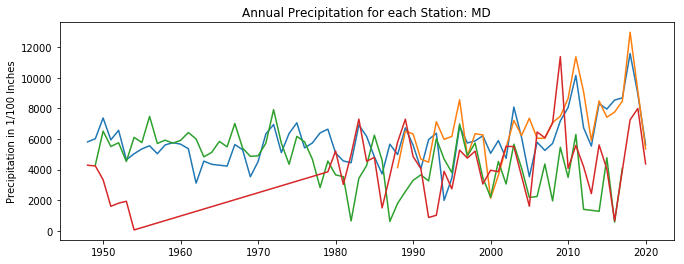

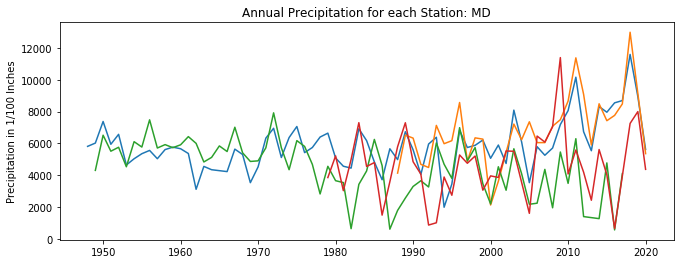

In [14]:
df_state_consecutive=filter_nonconsecutive_years(df_state, max_years_skipped=2)
simple_annual_sums_line(df_state, state_str)
simple_annual_sums_line(df_state_consecutive, state_str)

In [15]:
def plot_num_stations(df_in, state_str):
    """
    Plot number of stations reporting data in each year for that state.
    Useful for states with large numbers of stations.
    
    Inputs:
    df_in : The dataframe with hourly rain data
    state_str: A string identifying which state the data belongs to - for title only
    """
    
    #Group data by year, then count the number of unique stations present per year
    station_count=df_in.groupby("Year").Station.nunique()
    
    #Generate plot
    plt.figure(figsize=(12,3))
    
    #Set limits a bit wider to give the plot room to breathe
    plt.xlim(station_count.index.min()-2,station_count.index.max()+2)
    plt.ylim(0, station_count.max()+2)
    
    #Plot the number of stations, use the year (index) as x-axis
    plt.bar(station_count.index, station_count, color="darkgrey")
    
    #Titles and labels
    plt.title(f'Number of Stations Reporting in {state_str}')
    plt.ylabel('# Unique Stations')

    plt.show()

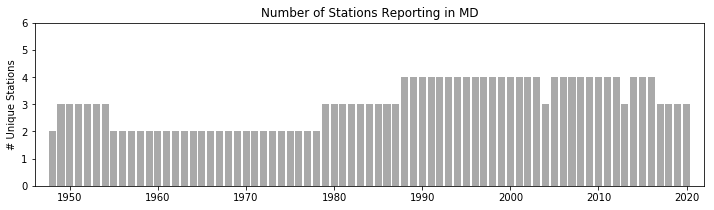

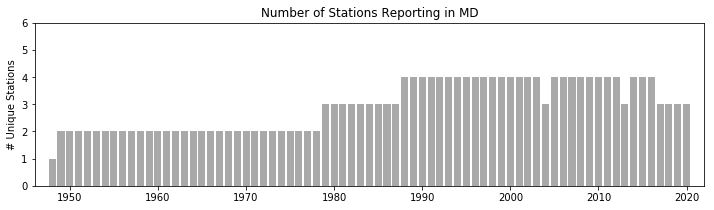

In [16]:
plot_num_stations(df_state,state_str)
plot_num_stations(df_state_consecutive,state_str)

In [17]:
def filter_min_station_duration(df_in, min_years=10):
    """
    Remove stations that were in operation for less than a specified number of years, 
    Years are measured from first observation to last observation.
    
    Inputs:
    df_in : The dataframe with hourly rain data
    min_years: The minimum years that each station must have reported for their data to be kept.
    """
    
    #Gather names of stations with less than the minimum time reporting
    stations_to_drop=[]
    
    for station in df_in.Station.unique():
        daily=df_in[(df_in.Station==station)]
        
        #Get datetime date of first/last reporting
        first_day=daily.Date.iloc[0]
        last_day=daily.Date.iloc[-1]
        
        #Gets the total number of days that station reported
        delta=(last_day-first_day).days
        #Id less than minimum, append the name to the list
        if delta<min_years/365:
            print(f'{station} - Open for {delta} days.')
            stations_to_drop.append(station)
            
    #Keep only stations whose names were not in the list        
    output=df_in[~df_in.Station.isin(stations_to_drop)]
            
    return output


In [18]:
df_state_consecutive=filter_min_station_duration(df_state_consecutive, min_years=10)

In [19]:

def rainfall_metrics_calc(df_in):
    """
    Takes the hourly station data and returns the precipitation metrics:Volume, Duration and Intensity for each occurance
    Returns each rainfall event as a seperately calculated row.
    
    Inputs:
    df_in : The dataframe with hourly rain data
    """
    
    #Seperate the rainfall and station information
    all_rain=df_in.iloc[:,5:].copy()
    tracking=df_in.iloc[:,0:5].copy()
    
    #Need to insert a row at the start to account for rain at the starting hour - otherwise the boolens get flipped
    all_rain.insert(loc=0, column='Start', value=0)
    
    #Binary rain-no rain
    all_rain_binary=all_rain!=0
    
    #Make a copy, then shift columns by one
    all_rain_binary_shift=all_rain_binary.copy()
    
    cols=all_rain.columns.to_list()
    cols=cols[1:]+[cols[0]]
    all_rain_binary_shift=all_rain_binary_shift[cols]
    
    #Set to arrays, then subtract the shifted array from the true array
    #The result has the start and stop indexes for each rainfall.
    #The -1 index is the last zero before the start(Don't count!), the 1 is an end (Count!)
    rain_times=np.array(all_rain_binary).astype(int)-np.array(all_rain_binary_shift).astype(int)
    
    #Counts the number of times a rainfall occured
    num_rainfalls=rain_times==-1
    num_rainfalls=num_rainfalls.sum(axis=1)
    
    
    
    #Seperate out the times where it rained only once
    #Can be processesd faster
    one_rain=all_rain[num_rainfalls==1]
    
    one_rain_metrics=tracking[num_rainfalls==1].copy()
    one_rain_metrics["Volume"]=one_rain.sum(axis=1)
    one_rain_metrics["Duration"]=(one_rain>0).sum(axis=1)
    
    
    #Seperate out the days that rained multiple times
    multi_rain=all_rain[num_rainfalls>1]
    multi_rain_tracking=tracking[num_rainfalls>1]
    multi_rain_binary=rain_times[num_rainfalls>1]
    
    #Obtain the start and stop indexes for all rainfall events
    row_start, col_start=np.where(multi_rain_binary == -1)
    row_stop, col_stop=np.where(multi_rain_binary == 1)
    
    #Shift the indexes by 1, since the 1st should be non-inclusive, and the last should be inclusive
    col_start=col_start+1 
    col_stop=col_stop+1
    

    
    def metrics_calculator3(i):
        """
        Takes the range shape[0] to loop through
        """
        #Select the correct event and tracking info
        event=multi_rain.iloc[row_start[i], col_start[i]:col_stop[i]]
        tracking_info=multi_rain_tracking.iloc[row_start[i], :].values
        
        #The sum is the total volume, the shape is the number of hours
        #concatenate the data and return
        out=np.append(tracking_info,[event.sum(), event.shape[0]]) 
        return out
        

    start=time.perf_counter()
    
    #Suprisingly, this takes longer if multi-threaded. Run as a straight loop
    metrics=[metrics_calculator3(i) for i in tqdm(range(row_start.shape[0]))]

    #Merge all rows ino a dataframe, rename columns
    metrics=pd.DataFrame(metrics)
    metrics.columns=tracking.columns.to_list()+['Volume','Duration']
    
    finish=time.perf_counter()
    
    print(f'Metrics finished in {round(finish-start,2)} seconds')
    
    #Glue on the single rainfalls, and re-sort
    
    metrics=pd.concat([metrics, one_rain_metrics], ignore_index=True)
    metrics=metrics.sort_values(['Station','Date']).reset_index(drop=True)
    metrics["Intensity"]=metrics["Volume"]/metrics["Duration"]
    
    return metrics

In [20]:
df_state_metrics=rainfall_metrics_calc(df_state_consecutive)

HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=28167.0), HTML(value='')))


Metrics finished in 17.88 seconds


In [21]:
df_state_metrics.head(15)

,Station,Date,Year,Month,Day,Volume,Duration,Intensity
0,ABERDEEN PHILLIPS FLD,1979-06-05,1979,6,5,10.0,1.0,10.0
1,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0
2,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0
3,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0
4,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0
5,ABERDEEN PHILLIPS FLD,1979-06-22,1979,6,22,10.0,1.0,10.0
6,ABERDEEN PHILLIPS FLD,1979-06-29,1979,6,29,20.0,2.0,10.0
7,ABERDEEN PHILLIPS FLD,1979-06-30,1979,6,30,60.0,1.0,60.0
8,ABERDEEN PHILLIPS FLD,1979-06-30,1979,6,30,10.0,1.0,10.0
9,ABERDEEN PHILLIPS FLD,1979-07-01,1979,7,1,40.0,2.0,20.0


In [22]:
def plot_metrics_line(df_in, state_str='', stations_in='all', ):
    """
    Plot each year's mean precipitation metrics:Volume, Duration and Intensity
    Returns as a double-axis plot (Vol and Duration) and a secondary single-axis plot (Intensity)
    
    Inputs:
    df_in : The dataframe with hourly rain data
    state_str: A string identifying which state the data belongs to - for title only, unneeded if region/State present
    stations_in: Allows filtering for specific stations, or show all stations. Must be a str or list of str.
    """    

    title_str=''
    
    #Try to filter for specific stations, if requested
    if stations_in.lower() != 'all':
        try:
            df_in=df_in[df_in.Station==stations_in]
            title_str=stations_in
        except:
            raise ValueError("That station is not present, please try again.")
    
    #Determine title of the plot
    else:
        #Checks for features of the dataframe (for later use)
        #If there is only one region, use that for the title
        if "Region" in df_in.columns:
            if len(df_in.Region.unique()) == 1:
                title_str=df_in.Region.unique()[0]
        #If there is only one state, overwrite the region - more specific
        if "State" in df_in.columns:
            if len(df_in.State.unique()) == 1:
                title_str=df_in.State.unique()[0]
        #If the dataframe has neither state nor region, use input value/display nothing
        else:
            title_str=state_str
        
  
 
    #Primary plot shows both Duration and Volume
    fig, ax1 = plt.subplots(figsize=(11,4))
    
    #Duration
    ax1.plot(df_in.groupby(['Year'])['Duration'].mean(), color='grey')
    ax1.set_ylabel(f'Mean Duration of Rainfall (Hours)', color='grey')
    ax1.tick_params(axis='y', labelcolor='grey')
    
    #Volume
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel(f'Mean Volume per Rainfall (1/100th Inch)', color='blue')  # we already handled the x-label with ax1
    ax2.plot(df_in.groupby(['Year'])['Volume'].mean(), color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    plt.title(f'Mean Rainfall Metrics: {state_str}')
    #plt.legend()
    plt.show()
    
    
    #Secondary plot to show intensity    
    fig, ax1 = plt.subplots(figsize=(11,4))
    
    ax1.plot(df_in.groupby(['Year'])['Intensity'].mean(), color='orange')
    ax1.set_ylabel(f'Mean Intensity of Rainfall (1/100th Inch/Hour)')
    ax1.tick_params(axis='y',)
    
    plt.title(f'Mean Rainfall Intensity: {state_str}')
    plt.show()




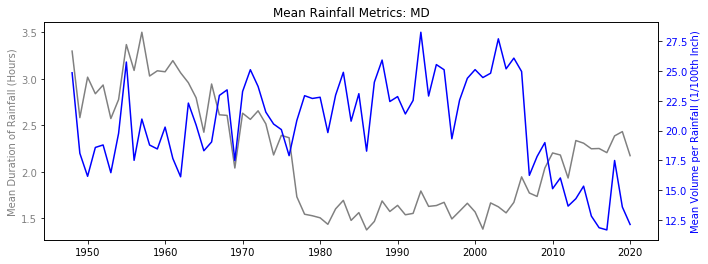

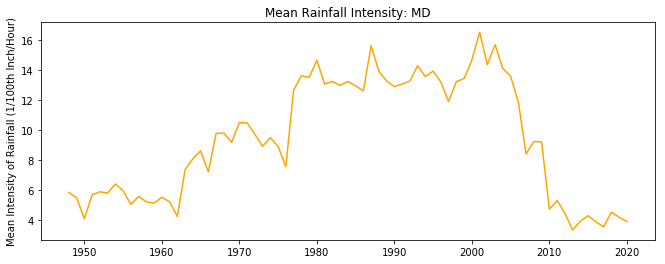

In [23]:
plot_metrics_line(df_state_metrics, state_str=state_str, stations_in='All')

In [24]:
def seperate_seasons(df_in, colors_only=False):
    """
    Categorize each date by what season it is in, using meteorological seasons, rather than the astronomical
    This means that we use rounded-off months starting on the 1st
    Also returns the hex colours that are used to consistantly represent each season.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data
    colors_only: If True, returns only the hex colours used for plotting
    """
    #Define the season names and colours in a dictionary
    season_colours={'Winter':'#486BF9', 'Spring':'#48F97E', 'Summer':'#F9D648','Fall':'#F96648'}
    
    #Return just the dictionary, if requested.
    if colors_only==True:
        return season_colours
    
    else:
        #Make a triple copy of each element in the order listed
        seasons= ['Winter', 'Spring', 'Summer','Fall']
        seasons = [ele for ele in seasons for i in range(3)] 

        # Offset the numbers of the month to put 12 (Dec.) into the Winter
        dates=[i for i in range(1,12+1)]
        dates=dates[-1:]+dates[:11]
        
        #Zip the seasons and months into a dic
        dates=dict(zip(dates,seasons))
        
        #Add a season column dependant on the current month column
        df_in=df_in.copy()
        df_in["Season"]=df_in.Month.replace(dates)
        
        return df_in, season_colours


In [25]:
df_state_metrics_season=seperate_seasons(df_state_metrics)[0]

In [26]:
df_state_metrics_season.head()

,Station,Date,Year,Month,Day,Volume,Duration,Intensity,Season
0,ABERDEEN PHILLIPS FLD,1979-06-05,1979,6,5,10.0,1.0,10.0,Summer
1,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0,Summer
2,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0,Summer
3,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0,Summer
4,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0,Summer


In [27]:
def plot_seasonal_metrics_line(df_in, stations_in='all', state_str=''):
    """
    Plot a line plot of the mean metrics for each year, seperated out by season
    Shows the seasonal differences, and historical differences
    
    Inputs:
    df_in : The dataframe with precipitation metrics data
    stations_in: Allows filtering for specific stations, or show all stations. Must be a str or list of str.
    state_str: A string identifying which state the data belongs to - for title only, unneeded if region/State present
    """
        
    #Add a season column to the dataframe, if needed
    if "Season" not in df_in.columns:
        df_in=df_in.copy()
        df_in, colours=seperate_seasons(df_in)
    else:
        colours=seperate_seasons(0, colors_only=True)
    
    #Determine title string
    title_str=''
    
    #If stations specified, filtered, and use as title
    if stations_in.lower() != 'all':
        try:
            df_in=df_in[df_in.Station==stations_in]
            title_str=stations_in
        except:
            raise ValueError("That station is not present, please try again.")
            
    #Else, select title by order of specificity, and input if no columns present
    else:
        #If there is only one region, use that for the title
        if "Region" in df_in.columns:
            if len(df_in.Region.unique()) == 1:
                title_str=df_in.Region.unique()[0]
        #If there is only one state, overwrite the region - more specific
        if "State" in df_in.columns:
            if len(df_in.State.unique()) == 1:
                title_str=df_in.State.unique()[0]
        else:
            title_str=state_str
    
    #Dictionary for the y-labels
    col_dict={'Volume':'Mean Volume per Rainfall (1/100th Inch)',
               'Duration':'Mean Duration per Rainfall (Hours)',
               'Intensity':'Mean Intensity per Rainfall (1/100th Inch/Hour)'}
  
    for col in col_dict:

        #Start the plotting
        plt.figure(figsize=(12,3))

        for season in colours:
            df_in2=df_in[df_in.Season == season].groupby(['Year'])[col].mean()

            plt.plot(df_in2, label=season, color=colours[season])

        plt.title(f'Mean {col} per Season : {title_str}')
        plt.ylabel(col_dict[col])
        plt.legend()
        plt.show()

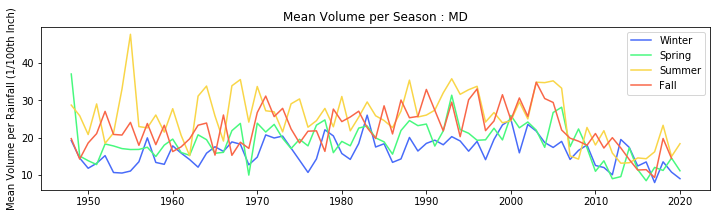

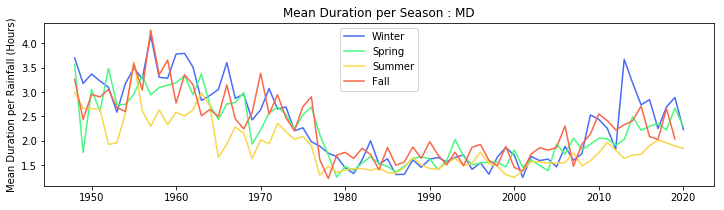

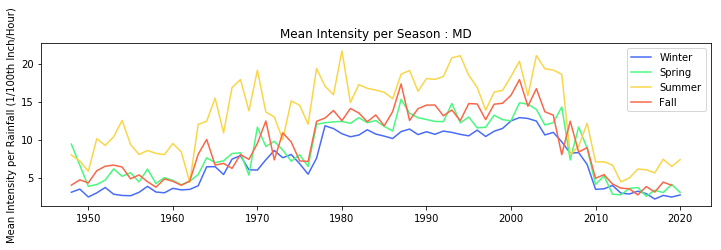

In [28]:
plot_seasonal_metrics_line(df_state_metrics_season, state_str=state_str )

In [29]:
def add_region(df_in, state_str):
    """
    Add the state and the region to the dataframe.
    Regions are clusters of nearby states, based off common groupings.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data
    state_str: String indicating which state the data is from
    """
    
    #Define the regions and the component states
    regions={"Pacific":['WA', 'OR','CA','NV','AK','HI',],
             'Rocky_Mountains':['MT','ID','WY','UT','CO', 'AZ','NM',],
             'Midwest':['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH'],
             'Southwest':['TX','OK', 'AR','LA',],
             'Southeast':['KY','TN','MS','AL','WV','VA','NC','SC','GA','FL',],
             'Northeast':['ME','NH','VT','NY','MA','RI','CT','PA','NJ','DE','MD','DC']}    
    
    #Flip the key:value pairs, to assign one region for each state
    region_flip={}
    for key in regions:
        for state in regions[key]:
            region_flip[state]=key

    #Add a State column, and a corresponding Region column to the dataframe
    try:
        df_in=df_in.copy()
        df_in.insert(loc=0, column="State", value=state_str)
        df_in.insert(loc=1, column='Region', value=df_in.State.replace(region_flip))
    except:
        print('Region already present')
    return df_in

In [30]:
df_state_metrics_region=add_region(df_state_metrics_season, state_str)
df_state_metrics_region.head()

,State,Region,Station,Date,Year,Month,Day,Volume,Duration,Intensity,Season
0,MD,Northeast,ABERDEEN PHILLIPS FLD,1979-06-05,1979,6,5,10.0,1.0,10.0,Summer
1,MD,Northeast,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0,Summer
2,MD,Northeast,ABERDEEN PHILLIPS FLD,1979-06-11,1979,6,11,10.0,1.0,10.0,Summer
3,MD,Northeast,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0,Summer
4,MD,Northeast,ABERDEEN PHILLIPS FLD,1979-06-17,1979,6,17,10.0,1.0,10.0,Summer


In [31]:
def data_pipeline(state_str, min_years=10):
    """
    The data pipeline: Takes a state abbreviation string, and downloads the corresponding data from NOAA
    Reformats data, calculates metrics, adds relevant columns and saves the resulting dataframe
    Created the save directory if it does not exist
    
    Inputs:
    state_str: String indicating which state to download
    min_years: Minimum number of years a station must report to be included
    """    
    
    
    def save_metrics(state_str, df_metrics):
        """
        Function to save the calculated metrics dataframe
        
        Inputs:
        state_str: String indicating which state to download
        df_metrics: Metrics dataframe to be saved
        """
        
        #Make the folder if needed, but don't overwrite if it's already there    
        if not os.path.isdir('./Stations/.Cleaned'):
             os.mkdir('./Stations/.Cleaned')

        #Save the dataframe        
        df_metrics.to_csv(f'./Stations/.Cleaned/{state_str}_metrics.csv')
        print(f'\n ------------------\n      {state_str} Saved\n ------------------\n')

        
    if os.path.isdir('./Stations/.Cleaned') and f'{state_str}_metrics.csv' in os.listdir('./Stations/.Cleaned'):
        print(f'Metrics present. Skipping {state_str}.')
    else:

        print(f'\n\n\n')
        print('***************\n\n')
        print(f'Now Starting: {state_str}')
        print('\n\n***************\n')
        download_state_data(state_str) #Download csvs
        df_state=import_state_raw(state_str) #Concat into one dataframe

        df_state=reformat_imported_df(df_state) #Reformat
        df_state=remove_non_rain_days(df_state) #Remove non-rain days
        df_state_consecutive=filter_nonconsecutive_years(df_state, max_years_skipped=2) #Filter non-consecutive years
        df_state_consecutive=filter_min_station_duration(df_state_consecutive, min_years=min_years) #Filter minimum duration

        print(f'\nBeginning metrics\n')
        print(f'----------------------\n')    
        df_state_metrics=rainfall_metrics_calc(df_state_consecutive) #Make rainfall metrics dataframe
        df_state_metrics=add_region(df_state_metrics, state_str) #Add region
        df_state_metrics=seperate_seasons(df_state_metrics)[0] #Add season


        save_metrics(state_str, df_state_metrics) #Save to file


In [32]:
data_pipeline('MD', min_years=10)

Metrics present. Skipping MD.


In [33]:
def gen_all_states():
    """
    Generates a list of all state abbreviations that have stations
    """
    #Load station inventory and extract state abbreviations
    filter_state=pd.read_csv('HPD_v02r02_stationinv_c20201027.csv')['State/Province'].unique()
    #Do not include US teritories
    filter_state=[ele for ele in filter_state if ele not in ['GU', 'AS', 'PR', 'VI', 'MP']] 
    return filter_state

for state in  tqdm(gen_all_states()):
    data_pipeline(state)

HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=48.0), HTML(value='')))

Metrics present. Skipping AL.
Metrics present. Skipping AZ.
Metrics present. Skipping AR.
Metrics present. Skipping CA.
Metrics present. Skipping CO.
Metrics present. Skipping CT.
Metrics present. Skipping DE.
Metrics present. Skipping FL.
Metrics present. Skipping GA.
Metrics present. Skipping ID.
Metrics present. Skipping IL.
Metrics present. Skipping IN.
Metrics present. Skipping IA.
Metrics present. Skipping KS.
Metrics present. Skipping KY.
Metrics present. Skipping LA.
Metrics present. Skipping ME.
Metrics present. Skipping MD.
Metrics present. Skipping MI.
Metrics present. Skipping MN.
Metrics present. Skipping MS.
Metrics present. Skipping MO.
Metrics present. Skipping MT.
Metrics present. Skipping NE.
Metrics present. Skipping NV.
Metrics present. Skipping NH.
Metrics present. Skipping NJ.
Metrics present. Skipping NM.
Metrics present. Skipping NY.
Metrics present. Skipping NC.
Metrics present. Skipping ND.
Metrics present. Skipping OH.
Metrics present. Skipping OK.
Metrics pr

In [34]:
def import_single_state_metrics(state_str):
    """
    Import a single state's calculated metrics
    
    Inputs:
    state_str: String indicating which state to import
    """
    try:
        metrics=pd.read_csv(f'./Stations/.Cleaned/{state_str}_metrics.csv', index_col=0)
    except:
        raise ValueError('State not found. Please ensure data exists.')
    #Set the date column as a datetime
    metrics["Date"] = pd.to_datetime(metrics["Date"])
    
    return metrics


def import_and_concat_states():
    """
    Import all states calculated metrics, concat into one large dataframe
    """
    all_states=[import_single_state_metrics(state) for state in gen_all_states()]
    all_states=pd.concat(all_states)
    
    return all_states


In [35]:
state_metrics=import_and_concat_states()
print(f'Shape  = {state_metrics.shape}')
state_metrics.head()

Shape  = (11528683, 11)


,State,Region,Station,Date,Year,Month,Day,Volume,Duration,Intensity,Season
0,AL,Southeast,ABBEVILLE,1948-06-16,1948,6,16,65.0,1.0,65.0,Summer
1,AL,Southeast,ABBEVILLE,1948-06-16,1948,6,16,1.0,1.0,1.0,Summer
2,AL,Southeast,ABBEVILLE,1948-06-17,1948,6,17,34.0,2.0,17.0,Summer
3,AL,Southeast,ABBEVILLE,1948-06-18,1948,6,18,6.0,2.0,3.0,Summer
4,AL,Southeast,ABBEVILLE,1948-06-20,1948,6,20,14.0,2.0,7.0,Summer


In [36]:
def plot_seasonal_metrics_stack(df_in, state_str=''):
    """
    Plot a stacked bar plot of the mean metrics for each year, seperated out by season
    Shows the seasonal differences, and historical differences
    
    Inputs:
    df_in : The dataframe with precipitation metrics data
    stations_in: Allows filtering for specific stations, or show all stations. Must be a str or list of str.
    state_str: A string identifying which state the data belongs to - for title only, unneeded if region/State present
    """
    
    #Add a season column to the dataframe, if needed
    if "Season" not in df_in.columns:
        df_in=df_in.copy()
        df_in, colours=seperate_seasons(df_in)
    else:
        colours=seperate_seasons(0, colors_only=True)
    
    
    #Generate the title sting based on the df's specificity
    title_str =''
    if "Region" in df_in.columns:
        if len(df_in.Region.unique()) == 1:
            title_str=df_in.Region.unique()[0]
    #If there is only one state, overwrite the region - more specific
    if "State" in df_in.columns:
        if len(df_in.State.unique()) == 1:
            title_str=df_in.State.unique()[0]
    
    else:
            title_str=state_str    
    
    #Set up dictionary of the percipitation metrics
    col_dict={'Volume':'Mean Volume of Rainfall (1/100th Inch)',
               'Duration':'Mean Duration of Rainfall (Hours)',
               'Intensity':'Mean Intensity of Rainfall (1/100th Inch/Hour)'}
    

    #Filter to make sure each season has the same amount (Usually an issue with winter)
    min_year=df_in.groupby('Season').Year.min().max()
    max_year=df_in.groupby('Season').Year.max().min()

    df_in=df_in[(df_in.Year>=min_year)&(df_in.Year<=max_year)]

    #Plot for all metrics
    for column in col_dict:
        df_in2=df_in.filter([column, "Season", "Year"], axis=1)
        
        #Keep track of the columns already plotted, for the bottom on the plot
        bottom=df_in2.groupby('Year')[column].sum()*0

        #Start plot
        plt.figure(figsize=(11,4))
        for season in df_in.Season.unique():
            #Filter for each season
            df_season=df_in2[df_in2.Season==season]
            #Get the mean of the column (Only the relevant column is left)
            df_season=df_season.groupby('Year').mean()
            
            #Make the barplot, adding the current value of the bottom to each depending on the year
            plt.bar(df_season.index, df_season[column] , bottom=bottom[df_season.index], color=colours[season], label=season)
            #Update the new bottom
            bottom=bottom+df_season[column]

        #Add titles and labels
        plt.title(f'Variations in Seasonal {column} over Time : {title_str}')
        plt.ylabel(col_dict[column])
        plt.legend(bbox_to_anchor=(1.15, .7))
        plt.show()


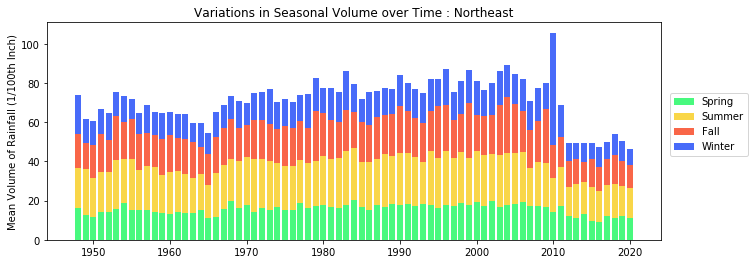

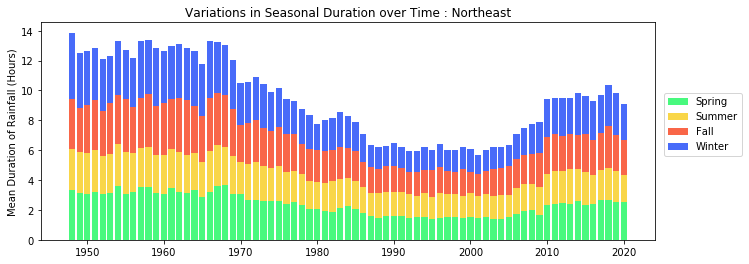

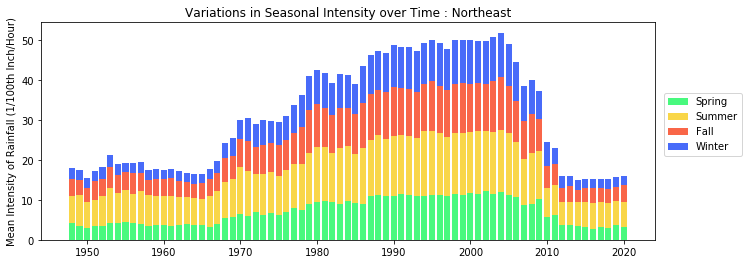

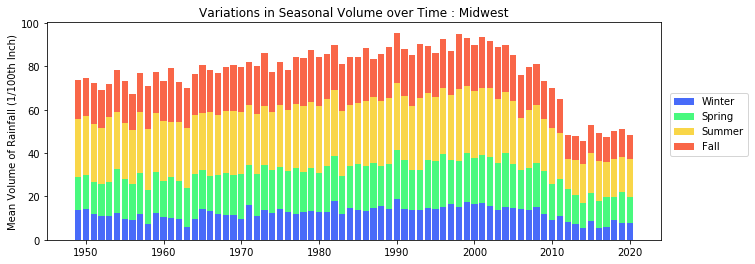

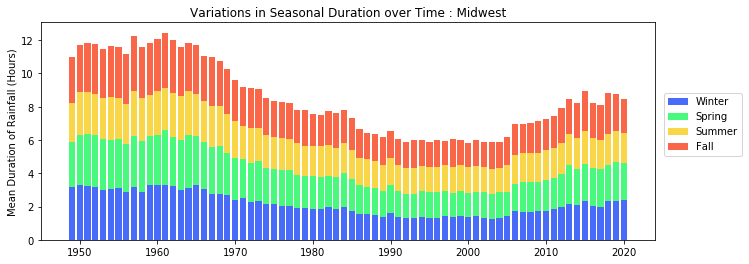

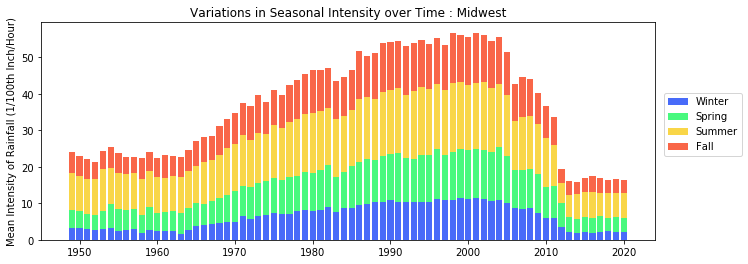

In [37]:
for region in ["Northeast", 'Midwest']:
#for region in state_metrics.Region.unique():
    df_r=state_metrics[state_metrics.Region==region]

    plot_seasonal_metrics_stack(df_r)


In [38]:
def generate_seasonal_deltas(df_in, column="Intensity", mode='All',  list_years=False, overall_only=False,):
    """
    Calculation function used to calculate the change in a metric from two time points. 
    The timepoints are based on the input, and can be two absolute timepoints, timepoints determined by the 
    maximum span of time all stations were simultaniously open, or the start and end time for each individual station.
    
    The metric is determined by the column input.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data, can be for an entire region at a time
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    overall_only: Option to return only the overall delta, and no seasonal delata
    """

    #Add a season column to the dataframe, drop extra columns
    if "Season" not in df_in.columns:
        df_in, colours=seperate_seasons(df_in)
    else:
        #Obtain the colours - used to loop through seasons
        colours=seperate_seasons(0, colors_only=True)
    #Drop unneeded columns
    df_in=df_in.filter(["State", "Station", 'Year',  "Season", column], axis=1)
    
    
    #Determine the span of years to use
    if list_years!=False: #If manual years specified
        #Check that the years are entered in a proper format
        if type(list_years)!=list or len(list_years)>2:
            raise ValueError('Please enter your list_years as [start year, end year]')
        else:
            #Set the smallest year entered to be the start, and the largest the end, then append as columns to all rows
            min_year=min(list_years) 
            max_year=max(list_years)
            df_in["Min_Year"]=min_year 
            df_in["Max_Year"]=max_year
    
    elif mode.lower()=='all':
        #Get the minimum of the max years and the max of the min year for all stations
        max_year=df_in.groupby("Station").Year.max().min()
        min_year=df_in.groupby("Station").Year.min().max()
        
        if min_year>max_year: 
            #Occurs when there is no span in which all stations are open (1st closed before the final opened)
            #In this case, reverse the years to obtain a large sample
            swap=max_year
            max_year=min_year
            min_year=swap
        #Append these values to all rows as columns    
        df_in["Min_Year"]=min_year
        df_in["Max_Year"]=max_year
        
    else:
       #Determine the start and end year for each individual station, and ad to that station's row as columns 
       max_year=df_in.groupby("Station").Year.max()
       min_year=df_in.groupby("Station").Year.min()
       df_in.index=df_in.Station
       df_in["Min_Year"]=min_year
       df_in["Max_Year"]=max_year
       df_in=df_in.reset_index(drop=True)

    
    def calc_deltas(df, out_col):
        #Calculate deltas, vectorized to improve speed
        
        #Get the average for the first and last 5 years as specified above for each station
        min_span=df[(df.Year>=df.Min_Year)&(df.Year<=df.Min_Year+5)].reset_index(drop=True)
        min_span=min_span.groupby('Station')[column].mean()
        
        max_span=df[(df.Year>=df.Max_Year-5)&(df.Year<=df.Max_Year)].reset_index(drop=True)
        max_span=max_span.groupby('Station')[column].mean()
        
        #Subtract the two values to get the delta
        delta=max_span-min_span
        delta.name=out_col
        return delta


    #If seasonal is not needed
    if overall_only==True:
        df_plot=pd.DataFrame(calc_deltas(df_in,'Overall'))

    else:
        #Calculate the overall and seasonal deltas
        all_deltas=calc_deltas(df_in,'Overall')
        season_deltas=[calc_deltas(df_in[df_in.Season==season], season) for season in df_in.Season.unique()]
        
        #Combine into one dataframe
        season_deltas.append(all_deltas)
        df_plot=pd.DataFrame(season_deltas).transpose()

    #Add elevation and location data
    filter_state=pd.read_csv('HPD_v02r02_stationinv_c20201027.csv', index_col='Name')
    filter_state=filter_state.filter(['Lat', 'Lon', 'Elev', 'State/Province'])
    filter_state=filter_state[filter_state['State/Province'].isin(df_in.State.unique(),)]    

    #Inner merge the dataframe to only append to stations that are present in the delta dataframe
    df_plot=df_plot.merge(filter_state,how='inner',left_index=True, right_index=True,)
    
    #Delete error codes
    df_plot=df_plot.replace({-999.9:np.nan})
    df_plot=df_plot.dropna()

    return df_plot




In [39]:

def stack_deltas(df_in, column="Intensity", season_interest='All', mode='All', list_years=False):
    """
    Stacked bar plot used to show changes in a metric from two time points. 
    The timepoints are based on the input, and can be two absolute timepoints, timepoints determined by the 
    maximum span of time all stations were simultaniously open, or the start and end time for each individual station.
    
    The metric is determined by the column input, can display both seasonal and overall change.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data, can be for an entire region at a time
    column: String indicating which precipitation metric to calculate deltas and return
    season_interest: Determine if all seasonal differences are desired, or only the combined response
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    """
    
    #Add a season column to the dataframe, if needed
    if "Season" not in df_in.columns:
        df_in=df_in.copy()
        df_in, colours=seperate_seasons(df_in)
    else:
        #Get the seasonal colours for plotting
        colours=seperate_seasons(0, colors_only=True)
    #Drop extra columns    
    df_in=df_in.filter(["State", "Station", 'Year',  "Season",'Region', column], axis=1)
    
    #Generate the seasonal deltas
    df_plot=generate_seasonal_deltas(df_in, column, mode, list_years=list_years)
    
    df_plot=df_plot.sort_values(by='Overall').reset_index().rename(columns={'index':'Station'})
    
    #return df_plot
    fig, ax= plt.subplots(figsize=(11,4))  
    
    #If not extracting seasonal data, plot a simple barplot with the deltas
    if season_interest.lower()=="combined":
        plt.bar(df_plot.Station, df_plot.Overall)
    
    #If extracting seasonal data, proceed.
    else:
        #For the seasonal stacked plots, need to seperate positive and negative deltas to stack properly
        #Prepare dictionaries to capture positive and negative bottom values 
        positive={station:0 for station in df_plot.Station.unique() }
        negative={station:0 for station in df_plot.Station.unique() }
        
                
        for season in df_in.Season.unique():
            #Isolate the season 
            df_season=df_plot[[season, 'Station']]
            df_season.index=df_season.Station
            
            #Capture the values for the bottom values in each season's plot 
            bottom=[]
            for station in df_season.Station.unique():
                val=df_season.loc[station, season]
                
                #Determine if delta is +/-, then extract and update correct bottoms
                if val>0:
                    bottom.append(positive[station])
                    positive[station]+=val
                else:
                    bottom.append(negative[station])
                    negative[station]+=val
                
            #Plot that season
            plt.bar(df_season.Station, df_season[season], bottom=bottom, color=colours[season], label=season)
    

    #Set titles and legend based on input params  
    if "Region" in df_in.columns:
        if len(df_in.Region.unique()) == 1:
            title_str=df_in.Region.unique()[0]
    #If there is only one state, overwrite the region - more specific
    if "State" in df_in.columns:
        if len(df_in.State.unique()) == 1:
            title_str=df_in.State.unique()[0]
    #If the dataframe has neither state nor region, use input value/display nothing
    else:
        title_str=''    
        

   #Get years for title   
    if list_years!=False:
        min_year=min(list_years)
        max_year=max(list_years)
    
    elif mode.lower()=='all':
        max_year=df_in.groupby("Station").Year.max().min()
        min_year=df_in.groupby("Station").Year.min().max()
    else:
        max_year=min_year=0
    
    if mode.lower()=='individual':
        title_string=f'Changes in Average {column}: {title_str}\n First 5 Years per Station vs Final 5 Years per Station'
    else:
        title_string=f'Changes in Average {column}: {title_str}\n {min_year}-{min_year+5} vs {max_year-5}-{max_year}'
    
    #Only plot lgend if there are multiple colours to display
    if season_interest.lower()=="all":
        plt.legend( bbox_to_anchor=(1.0, .9))


    #Set the rest of the plot params
    ax.axhline(y=0, color='k')
    plt.ylabel(f'Change in Average {column}')
    plt.xticks( rotation='vertical', size=6)
    plt.title(title_string)
    plt.show()


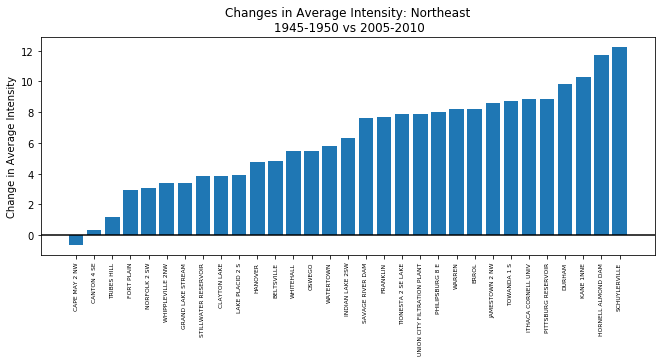

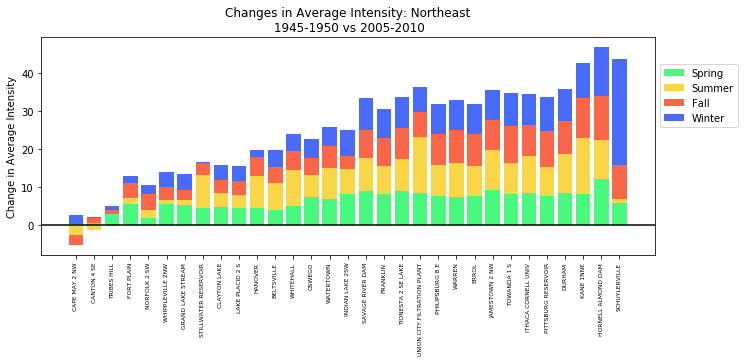

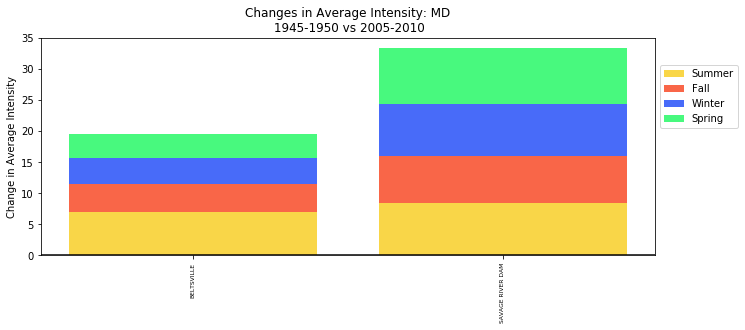

In [40]:
df_r=state_metrics[state_metrics.Region=='Northeast']
stack_deltas(df_r, column='Intensity', season_interest='Combined', mode='All', list_years=[1945,2010])

df_r=state_metrics[state_metrics.Region=='Northeast']
stack_deltas(df_r, column='Intensity', season_interest='All', mode='All', list_years=[1945,2010])

df_r=state_metrics[state_metrics.State=='MD']
stack_deltas(df_r, column='Intensity', season_interest='All', mode='All', list_years=[1945,2010])



In [41]:
def plot_elevations(df_in, column, mode, list_years=False ):
    """
    Scatterplot correlating the elevation of the station and changes in a metric from two time points. 
    Displays both seasonal and overall changes.
    The timepoints are based on the input, and can be two absolute timepoints, timepoints determined by the 
    maximum span of time all stations were simultaniously open, or the start and end time for each individual station.
    
    The metric is determined by the column input, can display both seasonal and overall change.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data, can be for an entire region at a time
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    """
    
    
    #Generate the title sting based on the df's specificity
    title_str =''
    if "Region" in df_in.columns:
        if len(df_in.Region.unique()) == 1:
            title_str='Region: ' + df_in.Region.unique()[0]
    #If there is only one state, overwrite the region - more specific
    if "State" in df_in.columns:
        if len(df_in.State.unique()) == 1:
            title_str='State: ' + df_in.State.unique()[0]
    else:
        title_str=''
            
            
    #Generate the deltas, and the colours for plotting        
    df_plot=generate_seasonal_deltas(df_in, column, mode, list_years=list_years)
    colours=seperate_seasons(0, colors_only=True)



    #Set titles and legend based on input params   
    if list_years!=False:
        full_string=f'Changes in Average {column} by Elevation of Station {title_str}\n Overall and per Season \n {min(list_years)} to {max(list_years)}'
         
    elif mode.lower()=='individual':
        full_string=f'Changes in Average {column} by Elevation\n {title_str}\nFirst 5 Years per Station vs Final 5 Years per Station'
    
    else:
        full_string=f'Changes in Average {column} by Elevation of Station {title_str}\n Overall and per Season \n'
    

    #Initialize the plot
    fig, ax= plt.subplots(figsize=(12,10))  
    plt.subplot(4, 1, 1)
    
    #Overall changes
    plt.scatter(df_plot.Elev, df_plot.Overall, color='black', label='Overall', s=4,)
    plt.title(full_string)
    plt.axhline(y=0, color='black', alpha=0.5)
    plt.legend(loc='lower right')
    plt.ylabel(f'Change in {column}')

    #Seasonal changes 
    i=3  #Loop through the subplot index for each season  
    for season in df_r.Season.unique():    
       plt.subplot(4, 2, i) #Set plot index
       plt.scatter(df_plot.Elev, df_plot[season], label=season, color=colours[season], s=4) #Scatterplot
       plt.legend(loc='lower right')
       plt.axhline(y=0, color='black', alpha=0.5)
       #Set if the axes are going to be labeled based on where they appear on the plot 
       b=False;
       if i>4:
           b=True #Label the bottom of the subplot
           plt.xlabel('Station Elevation(ft)')

       plt.tick_params(labelbottom=b, )
       i+=1
        
    plt.show()

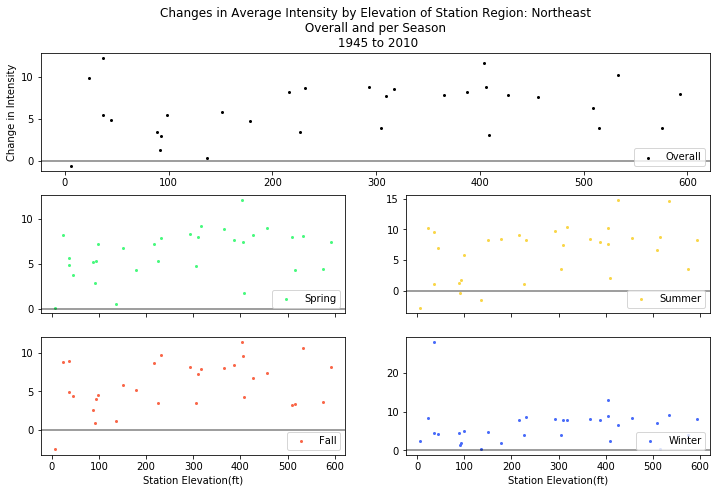

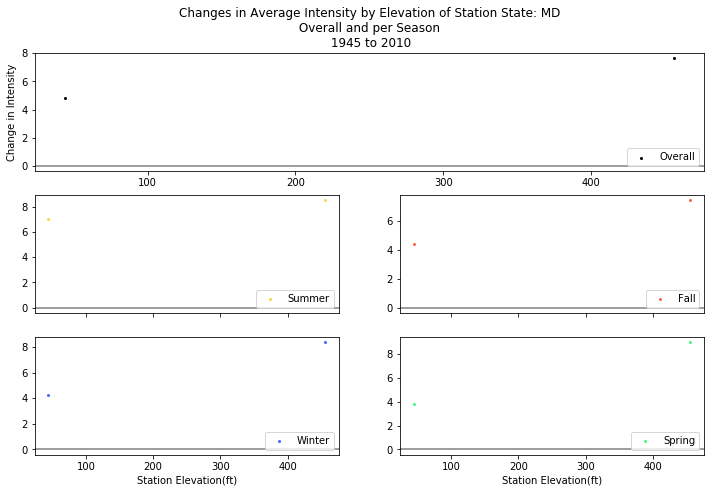

In [42]:

df_r=state_metrics[state_metrics.Region=='Northeast']
plot_elevations(df_r, column='Intensity', mode='All', list_years=[1945,2010])

df_r=state_metrics[state_metrics.State=='MD']
plot_elevations(df_r, column='Intensity',  mode='All', list_years=[1945,2010])


In [43]:
"""
Cartopy imports
"""


import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.patheffects as PathEffects
from matplotlib.colors import Normalize
import matplotlib
from matplotlib import cm


In [44]:

def stations_multiregion(df_metrics, column, mode, list_years, regions='All'):
    """
    Calculation function used to pass alll regions in a dataset into generate_seasonal_deltas() and merge into one large dataframe
    Can be used on all stations in the United States simultaniously.
    
    
    The metric is determined by the column input.
    
    Inputs:
    df_in : The dataframe with  all regions precipitation metrics data. Can be filtered, if desired.
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    regions: A list of regions to display, 'All' by default.
    """
    
    #Check inputs for the regional filtering
    if type(regions)==list:
        #Check if any inputs are not present in the list of regions
        if sum([item not in df_metrics.Region.unique().tolist() for item in regions]):
            raise ValueError(f'Please ensure all regions listed are in the approved regions.\n Options are {df_metrics.Region.unique().tolist()}')
    elif regions=='All':
        #Make list of all regions to loop through
        regions=df_metrics.Region.unique().tolist()
    else:
        raise ValueError('Error: Unknown region input.')
    
    #Apply generate_seasonal_deltas for all regions, concat into one dataframe
    gather=[]
    for region in tqdm(regions):
        df_region=df_metrics[df_metrics.Region==region]
        gather.append(generate_seasonal_deltas(df_region, column=column, mode=mode,
                                               list_years=list_years, overall_only=True ))
    gather=pd.concat(gather)
    return gather



def delta_map_stations(df_metrics, column, mode, list_years, regions='All'):
    """
    Plot the changes in precipitation metrics for each station on their geographic location on a map of the continental united states.
    Can be used on all stations in the United States simultaniously.
    
    The metric is determined by the column input.
    
    Inputs:
    df_metrics : The dataframe with  all regions precipitation metrics data. Can be filtered, if desired.
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    regions: A list of regions to display, 'All' by default.
    """
    
    #Feed the full dataset into stations_multiregion() to obtain all deltas for each station
    gradient_df=stations_multiregion(df_metrics, column=column, mode=mode, list_years=list_years, regions=regions )
    
    #Calculate the RBGA Values to be used in the heatmap
    
    #Create the normalized gradient centered on the zero between the max and negative max
    #Find the max distance from 0 
    max_gradient=np.array([abs(gradient_df.Overall.min()), abs(gradient_df.Overall.max())]).max()
    #Then output a color for each value
    norm = Normalize(vmin=-max_gradient, vmax=max_gradient)
    color_vals=[cm.coolwarm(norm(val),) for val in gradient_df.Overall ]

    
    #Add a column to the dataframe for the RGBA values we calculated
    gradient_df['value']=color_vals
    
    #Initialize the figure
    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    
    #Center the map on the US
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    
    #Load the shapefile, and the correct borders
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
    #Set the background colors/visibility
    ax.outline_patch.set_visible(False)  
    ax.background_patch.set_visible(True)
    ax.background_patch.set_facecolor('k')
    
    #Set title  
    if list_years!=0:
        title_str= f'Overall Change in {column}, {min(list_years)} to {max(list_years)} \n Displaying {gradient_df.shape[0]} Stations in the US'
    else:
        title_str=f'Overall Change in {column}\n Displaying {gradient_df.shape[0]} Stations in the US'
    ax.set_title(title_str)
    
    #Loop through each state and paint the borders and facecolor
    for astate in shpreader.Reader(states_shp).records():
        # `astate.geometry` is the polygon to plot
        ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                          facecolor='lightyellow', edgecolor='grey')
        
    #Add each station to the map using the RGBA colour we generated and their lat/lon data we appended    
    for i in range(gradient_df.shape[0]):
       plt.plot(gradient_df.Lon[i],gradient_df.Lat[i], color=gradient_df.value[i], markersize=5, marker='o',transform=ccrs.Geodetic() )
    
    
    #Add stand-alone colourbar to show the direction of the gradient
    c_map_ax = fig.add_axes([0.91, 0.33, 0.01, 0.36])
    c_map_ax.axes.get_xaxis().set_visible(False)
    c_map_ax.axes.get_yaxis().set_visible(False)
    matplotlib.colorbar.ColorbarBase(c_map_ax, cmap='coolwarm', orientation = 'vertical')
    
    plt.show()

In [45]:

def generate_state_deltas(df_in, column="Intensity", mode='All',  list_years=False, overall_only=False,):
    """
    Calculation function used to calculate the change in a metric from two time points, averaged across each state.
    Sends the input data to generate_seasonal_deltas(), then averages for each station in the state, returns the state value.
    
    The metric is determined by the column input.
    
    Inputs:
    df_in : The dataframe with precipitation metrics data, can be for an entire region at a time
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    overall_only: Option to return only the overall delta, and no seasonal delata
    """
    
    df_state=generate_seasonal_deltas(df_in, column, mode, list_years=list_years, overall_only=overall_only)
    df_state=df_state.groupby('State/Province').mean()
    return df_state
    

def states_multiregion(df_metrics, column, mode, list_years=False, regions='All'):
    """
    Calculation function used to pass all regions in a dataset into generate_state_deltas() and merge into one large dataframe
    Can be used on all stations in the United States simultaniously.
    
    The metric is determined by the column input.
    
    Inputs:
    df_in : The dataframe with  all regions precipitation metrics data. Can be filtered, if desired.
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    regions: A list of regions to display, 'All' by default.
    """

    #Check inputs for the regional filtering
    if type(regions)==list:
        #Check if any inputs are not present in the list of regions
        if sum([item not in df_metrics.Region.unique().tolist() for item in regions]):
            raise ValueError(f'Please ensure all regions listed are in the approved regions.\n Options are {df_metrics.Region.unique().tolist()}')
    elif regions=='All':
        #Make list of all regions to loop through
        regions=df_metrics.Region.unique().tolist()
    
    #Apply generate_state_deltas for all regions, concat into one dataframe
    gather=[]
    for region in tqdm(regions):
        df_region=df_metrics[df_metrics.Region==region]
        gather.append(generate_state_deltas(df_region, column=column, mode=mode,
                                               list_years=list_years, overall_only=True ))
    gather=pd.concat(gather)
    return gather


def us_state_abbrev():
    """
    A Utiliy function that returna a dictionary of all states and US territories, and their abbrviations.
    Used for looping through cartopy states
    """
    full=['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado',
          'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
          'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
          'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 
          'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
          'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
          'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
          'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
    abbrev=['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'GU', 'HI', 'ID', 'IL', 'IN',
            'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM',
            'NY', 'NC', 'ND', 'MP', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA',
            'WA', 'WV', 'WI', 'WY']
    
    dict_abbrev=dict(zip(full,abbrev))
            
    return dict_abbrev

def delta_map_states(df_metrics, column, mode, list_years=False, regions='All'):
    """
    Plot the mean changes in precipitation metrics for each state on a map of the continental united states.
    Can be used on all states simultaniously.
    
    The metric is determined by the column input.
    
    Inputs:
    df_metrics : The dataframe with  all regions precipitation metrics data. Can be filtered, if desired.
    column: String indicating which precipitation metric to calculate deltas and return
    mode: How to determint the timepoints used to calculate deltas
            "All": Use the span of time in which all stations were open
            "Individual" : Use the first and final years for each individual station
    list_years: An user-enforced start and stop point, overrides mode
    regions: A list of regions to display, 'All' by default.
    """    

    
    #Feed the full dataset into states_multiregion() to obtain all deltas for each state
    gradient_df=states_multiregion(df_metrics, column=column, mode=mode, list_years=list_years, regions=regions )
    
    state_abbrev=us_state_abbrev()
    
    #Calculate the RBGA Values to be used in the heatmap
    
    #Create the normalized gradient centered on the zero between the max and negative max
    #Find the max distance from 0 
    max_gradient=np.array([abs(gradient_df.Overall.min()), abs(gradient_df.Overall.max())]).max()
    #Then output a color for each value
    norm = Normalize(vmin=-max_gradient, vmax=max_gradient)
    color_vals=[cm.coolwarm(norm(val),) for val in gradient_df.Overall ]

    
    #Add a column to the dataframe for the RGBA values we calculated
    gradient_df['value']=color_vals
    
    #Initialize the figure
    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

    #Center the map on the US
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
    
    #Load the shapefile, and the correct borders
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)
    
    #Set the background colors/visibility
    ax.outline_patch.set_visible(False)  
    ax.background_patch.set_visible(True)
    ax.background_patch.set_facecolor('k')
    
    
    #Set title  
    if list_years!=0:
        title_str= f'Overall Change in {column}, {min(list_years)} to {max(list_years)} \n Displaying {gradient_df.shape[0]-2} Reporting States in the Continental US'
    else:
        title_str=f'Overall Change in {column}\n Displaying {gradient_df.shape[0]-2} Reporting States in the Continental US'
    ax.set_title(title_str)
    
    
    #Loop through each state and paint the borders and facecolor according to the RGBA values we calculated
    for astate in shpreader.Reader(states_shp).records():
        try:
            state=state_abbrev[astate.attributes['name']]
            ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                              facecolor=gradient_df.loc[state].value, edgecolor='grey')
        except:
            #This may be a territory, or a state which has not stations(eg, RI)
            pass
        

    
    #Add stand-alone colourbar to show the direction of the gradient
    c_map_ax = fig.add_axes([0.91, 0.33, 0.01, 0.36])
    c_map_ax.axes.get_xaxis().set_visible(False)
    c_map_ax.axes.get_yaxis().set_visible(False)
    matplotlib.colorbar.ColorbarBase(c_map_ax, cmap='coolwarm', orientation = 'vertical')
    
    
    plt.show()

In [46]:

def delta_maps(df_metrics, col, time_plot, plot_method='state', regions='All'):
    """
    Shell function used to plot the changes in precipitation metrics on a map of the United States.
    Can be used to plot either each individual station, or state-wide averages, depending on plot_method.
    Can be used on all stations/states in the United States simultaniously.
    
    The metric is determined by the column input.
    
    Inputs:
    df_metrics : The dataframe with  all regions precipitation metrics data. Can be filtered, if desired.
    col: String indicating which precipitation metric to calculate deltas and return
    time_plot: How to determint the timepoints used to calculate deltas. Can be string or list of two years.
                "All": Use the span of time in which all stations were open
                "Individual" : Use the first and final years for each individual station
                [start_year, end_year]: Enter a list of two ints to select the start and end year.
    regions: A list of regions to display, 'All' by default.
    """
    
    #determine the plot mode
    if type(time_plot) ==list:
        if len(time_plot)!=2:
            raise ValueError('Please set time_plot to "All", "Individual" or a list of [start_year, end_year].')
        else:
            mode='All'; list_years=time_plot

    elif type(time_plot) == str:
        if time_plot.lower() not in ['all', 'individual']:
            raise ValueError('Please set time_plot to "All", "Individual" or a list of [start_year, end_year].')

        else:
            mode=time_plot; list_years=False

    #Correct recion, if needed
    if type(regions)==str and regions.lower()!='all':
        regions=[regions]

    
    #Select the appropriate plotting method
    if plot_method.lower() not in ['state', 'station']:
        raise ValueError('Please set plot_method to "State" or "Station".')
    
    elif plot_method.lower() == 'state':
        delta_map_states(df_metrics, col, mode=mode, list_years=list_years, regions=regions)   
    
    elif plot_method.lower() == 'station':
        delta_map_stations(df_metrics, col, mode=mode, list_years=list_years, regions=regions)   
        


HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=6.0), HTML(value='')))

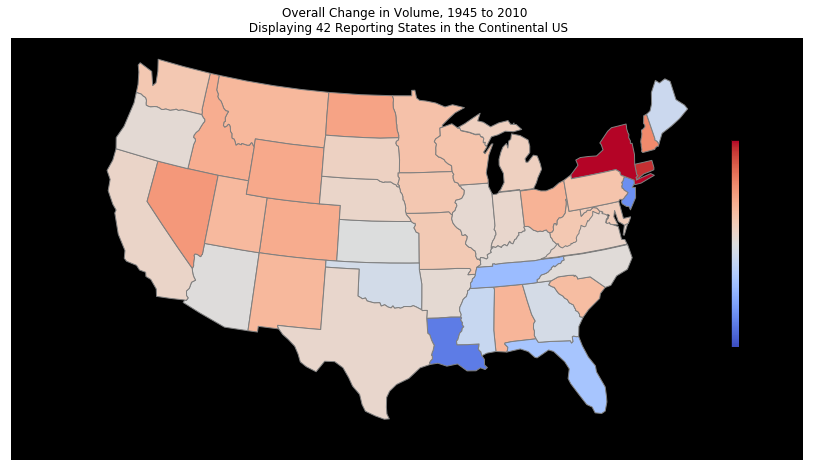

HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=6.0), HTML(value='')))

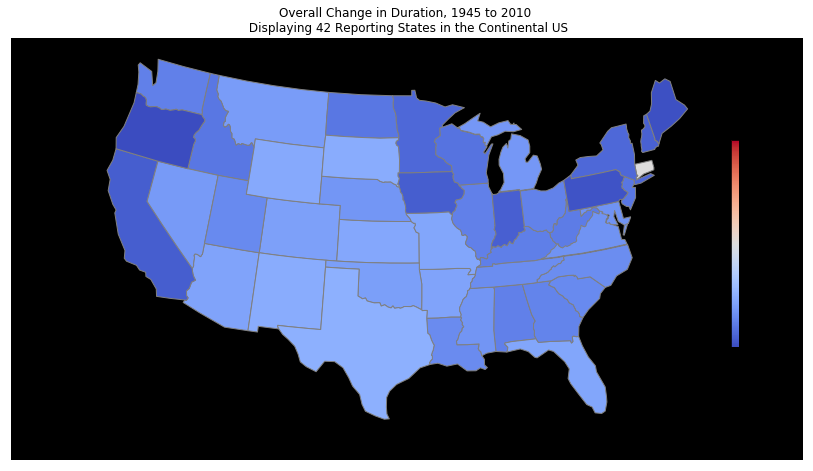

HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=6.0), HTML(value='')))

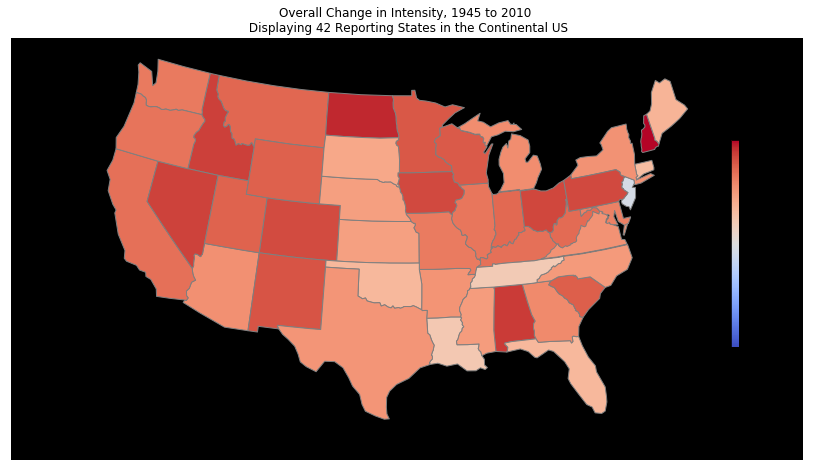

In [48]:
delta_maps(state_metrics, col='Volume', time_plot=[1945,2010], plot_method='state', regions='All')
delta_maps(state_metrics, col='Duration', time_plot=[1945,2010], plot_method='state', regions='All')
delta_maps(state_metrics, col='Intensity', time_plot=[1945,2010], plot_method='state', regions='All')


HBox(children=(HTML(value=''), FloatProgress(value=0.0, max=6.0), HTML(value='')))

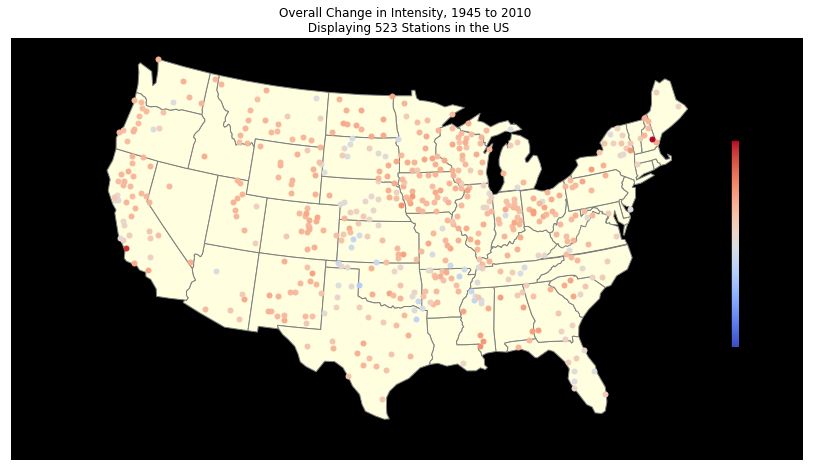

In [50]:
delta_maps(state_metrics, col='Intensity', time_plot=[1945,2010], plot_method='station', regions='All')

## Overall Findings

Weather patterns are changing rapidly throughout the United States. 
Using data collected from across the United States, over a period of 70 years it is clear that the patterns of preciptation are becoming *shorter in duration*, and this is often accompanied by a change in volume as well.

**This can have two major implications:    **

*1) The volume does not decrease, meaning intensity is increasing. *  

    Increasing intensity increases runoff, leading to decreased soil condition as topsoil is erroded. This in turn leads to worse farming conditions, and a higher liklihood of landslides in sloped areas.  
    
*2) The volume does decrease, meaning there is less total volume being deposited. *  

    This is an obvious problem, as humans and the environment are very dependant on having a steady supply of water.

**Using these models, you can predict where future rainfall patterns are likely to deteriorate, and put in place preventative measures.**  
For example, you could emphasise the growth of water-efficient crops in areas likely to see decreased total volume, and put increased bank supports in sloped areas seeing increased intensity.
    

A major aspect of this project that pushed my skills was the heavy emphasis on optimization, and handling data with forethought.  
Because of the scale of this dataset (11,528,683 rows when all metrics are concatinated), optimization was absolutely required whenever performing manipulations on any aspect of the data. While in previous projects I have always done my best to write efficient code, this dataset did not allow for any inefficiencies. This forced me to think and program in a different way - mandating vectorization rather than for loops, in dataframes, for example. 

This project has strongly improved my skills in handling large datasets, and in efficiency in general.